# TNT Single-Mode: Large-Amplitude Oscillatory Shear

## Learning Objectives
1. Understand LAOS response of transient network materials
2. Fit TNT single-mode model to large-amplitude oscillatory data
3. Analyze Lissajous curves (stress vs. strain)
4. Extract higher harmonics via FFT analysis
5. Compare constant vs. Bell breakage nonlinearity
6. Perform Bayesian inference for parameter uncertainty

## Prerequisites
- Understanding of transient network theory (Notebook 01)
- Familiarity with SAOS (Notebook 05)
- Knowledge of nonlinear viscoelasticity and Fourier analysis

## Runtime Estimate
- NLSQ fitting: ~5-15 seconds
- Bayesian inference (demo): ~60-120 seconds
- Total: ~4-8 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_pnas_laos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
)

## 2. Theory

## Large-Amplitude Oscillatory Shear (LAOS)

### Physical Mechanism

In LAOS, a large-amplitude sinusoidal strain is applied:

$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where γ₀ is **large enough** to induce nonlinear response (typically γ₀ > 0.1).

### Nonlinear Response

Unlike SAOS (small γ₀), the stress response contains **higher harmonics**:

$$
\sigma(t) = \sum_{n=1,3,5,...} \left[ G'_n(\gamma_0, \omega) \sin(n\omega t) + G''_n(\gamma_0, \omega) \cos(n\omega t) \right]
$$

- **Fundamental (n=1)**: Same frequency as input
- **Higher harmonics (n=3,5,...)**: Odd harmonics from material nonlinearity

### Lissajous Curves

Lissajous plots (stress vs. strain, stress vs. strain rate) reveal:
- **Linear response**: Ellipse
- **Nonlinear response**: Distorted ellipse with higher harmonics

### TNT Nonlinearity Sources

**Constant breakage**: β = 1/τ_b
- **Nearly linear** response (UCM-like)
- Weak nonlinearity from geometry only

**Bell breakage**: β = (1/τ_b) exp(ν τ/G)
- **Strong nonlinearity** from stress-dependent bond breaking
- Shear thinning + higher harmonics

### Fourier Analysis

To quantify nonlinearity, compute harmonic intensities:

$$
I_n = \frac{|\mathcal{F}[\sigma(t)]_n|}{|\mathcal{F}[\sigma(t)]_1|}
$$

where $\mathcal{F}$ is the Fourier transform.

Typical values:
- I₃/I₁ < 0.01: Nearly linear
- I₃/I₁ = 0.05-0.2: Moderate nonlinearity
- I₃/I₁ > 0.2: Strong nonlinearity

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Network stiffness | 1-1000 Pa |
| Breakage time | $\tau_b$ | Relaxation time | 0.01-100 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |
| Bell parameter | $\nu$ | Stress sensitivity (Bell only) | 0.1-2 |

## 3. Load Data

In [2]:
# Load LAOS data
omega = 1.0  # rad/s
strain_amplitude_index = 5
t_data, strain, stress = load_pnas_laos(omega=omega, strain_amplitude_index=strain_amplitude_index)

# Extract strain amplitude
gamma_0 = float(np.max(np.abs(strain)))

print(f"Data shape: {len(t_data)} points")
print(f"Time range: {t_data.min():.3f} - {t_data.max():.3f} s")
print(f"Strain amplitude: γ₀ = {gamma_0:.3f}")
print(f"Angular frequency: ω = {omega:.1f} rad/s")
print(f"Stress range: {stress.min():.2f} - {stress.max():.2f} Pa")

Data shape: 200 points
Time range: 0.005 - 66.000 s
Strain amplitude: γ₀ = 0.512
Angular frequency: ω = 1.0 rad/s
Stress range: -17.27 - 20.43 Pa


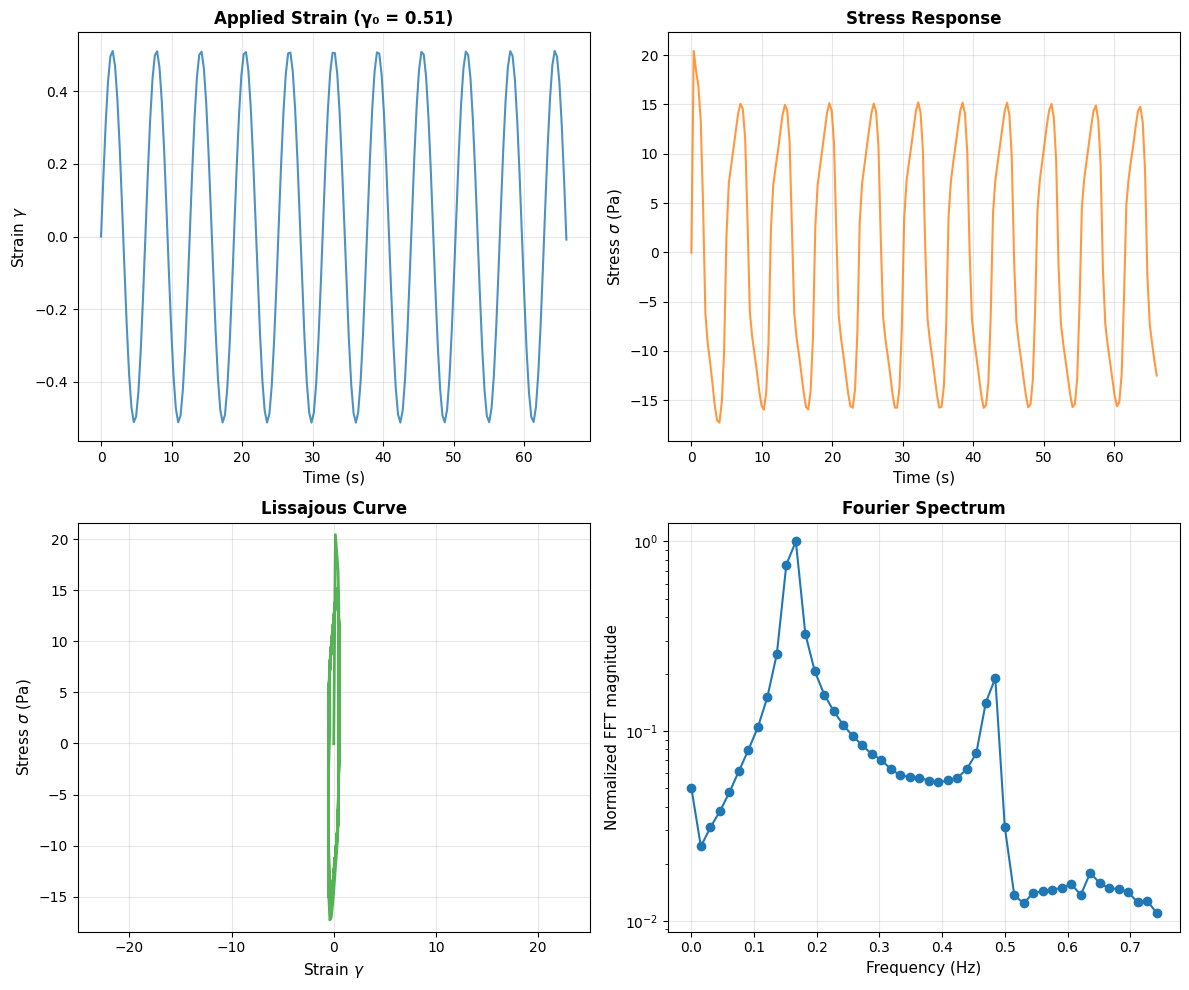


Harmonic Analysis (Data):
  I₃/I₁ = 0.1901
  I₅/I₁ = 0.0947
  → Moderate nonlinearity


In [3]:
# Plot raw data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Strain vs time
ax = axes[0, 0]
ax.plot(t_data, strain, '-', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Strain $\gamma$', fontsize=11)
ax.set_title(f'Applied Strain (γ₀ = {gamma_0:.2f})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Stress vs time
ax = axes[0, 1]
ax.plot(t_data, stress, '-', linewidth=1.5, alpha=0.8, color='C1')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Stress Response', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Lissajous curve (stress vs strain)
ax = axes[1, 0]
ax.plot(strain, stress, '-', linewidth=2, alpha=0.8, color='C2')
ax.set_xlabel(r'Strain $\gamma$', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Lissajous Curve', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# 4. FFT harmonics
ax = axes[1, 1]
# Compute FFT of stress
fft_stress = np.fft.rfft(stress)
fft_freq = np.fft.rfftfreq(len(t_data), t_data[1] - t_data[0])
fft_mag = np.abs(fft_stress)

# Normalize to fundamental
fundamental_idx = np.argmax(fft_mag[1:]) + 1  # Skip DC component
fft_mag_norm = fft_mag / fft_mag[fundamental_idx]

ax.semilogy(fft_freq[:50], fft_mag_norm[:50], 'o-', markersize=6, linewidth=1.5)
ax.set_xlabel('Frequency (Hz)', fontsize=11)
ax.set_ylabel('Normalized FFT magnitude', fontsize=11)
ax.set_title('Fourier Spectrum', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute harmonic ratios
freq_fundamental = omega / (2 * np.pi)  # Hz
idx_1 = np.argmin(np.abs(fft_freq - freq_fundamental))
idx_3 = np.argmin(np.abs(fft_freq - 3 * freq_fundamental))
idx_5 = np.argmin(np.abs(fft_freq - 5 * freq_fundamental))

I_1 = fft_mag[idx_1]
I_3 = fft_mag[idx_3] if idx_3 < len(fft_mag) else 0
I_5 = fft_mag[idx_5] if idx_5 < len(fft_mag) else 0

print(f"\nHarmonic Analysis (Data):")
print(f"  I₃/I₁ = {I_3/I_1:.4f}")
print(f"  I₅/I₁ = {I_5/I_1:.4f}")
if I_3/I_1 < 0.01:
    print(f"  → Nearly linear response")
elif I_3/I_1 < 0.2:
    print(f"  → Moderate nonlinearity")
else:
    print(f"  → Strong nonlinearity")

## 4. NLSQ Fitting

In [4]:
# Create model and fit
model = TNTSingleMode(breakage="constant")

start_time = time.time()
result = model.fit(t_data, stress, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")


NLSQ fitting completed in 34.04 seconds

Fitted Parameters:
  G = 1.5706e+02
  tau_b = 2.0154e-01
  eta_s = 5.4607e-24


In [5]:
# Compute fit quality metrics
metrics = compute_fit_quality(stress, model.predict(t_data, test_mode="laos", gamma_0=gamma_0, omega=omega))
print(f"\nFit Quality:")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4e} Pa")
print(f"  NRMSE = {metrics['NRMSE']*100:.2f}%")


Fit Quality:
  R² = 0.929857
  RMSE = 3.0548e+00 Pa
  NRMSE = 8.10%


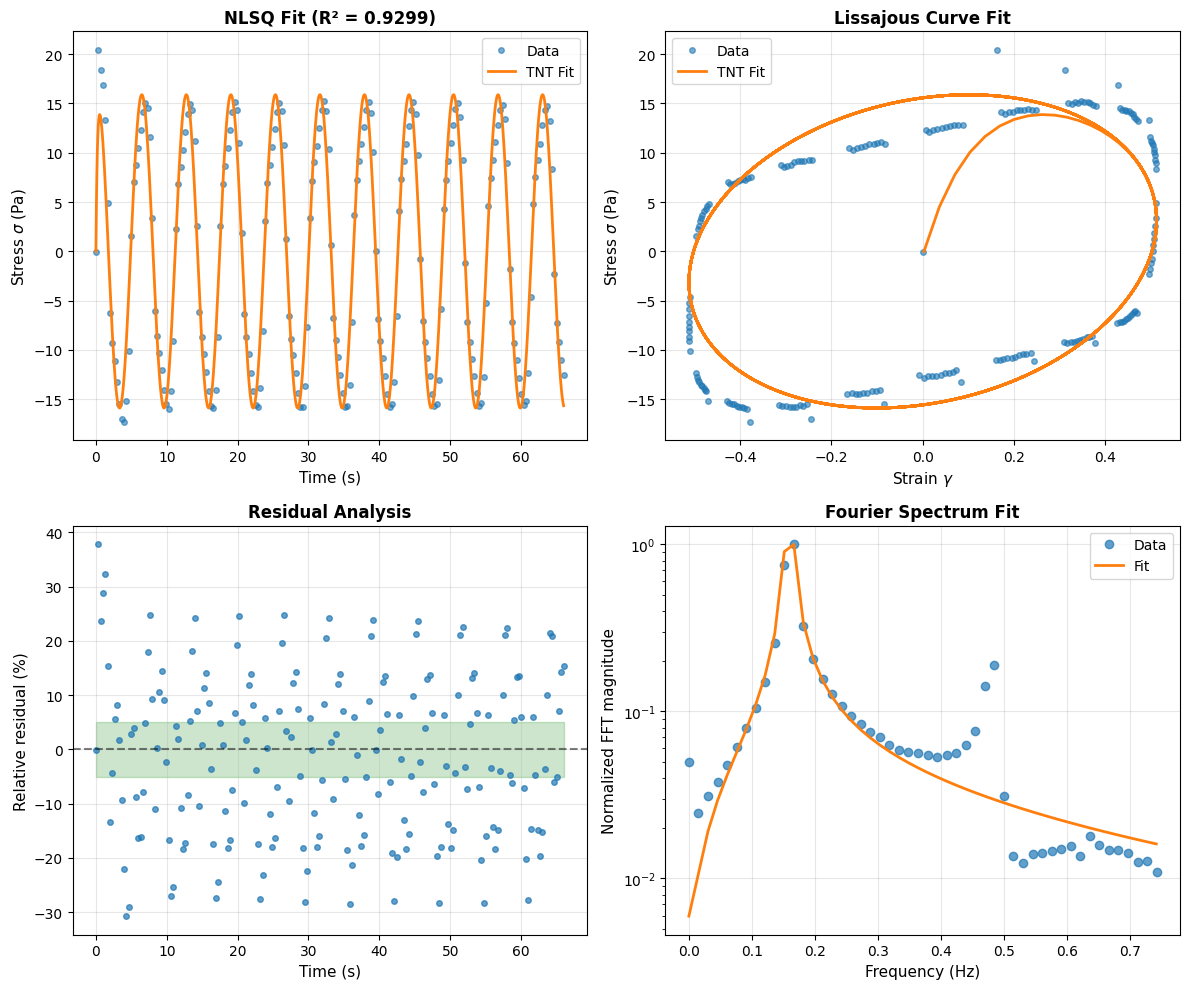

In [6]:
# Plot fit overlay
time_fine = np.linspace(t_data.min(), t_data.max(), 1000)
stress_pred = model.predict(time_fine, test_mode="laos", gamma_0=gamma_0, omega=omega)
strain_fine = gamma_0 * np.sin(omega * time_fine)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Stress vs time
ax = axes[0, 0]
ax.plot(t_data, stress, 'o', label='Data', markersize=4, alpha=0.6)
ax.plot(time_fine, stress_pred, '-', label='TNT Fit', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title(f'NLSQ Fit (R² = {metrics["R2"]:.4f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Lissajous curve
ax = axes[0, 1]
ax.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.6)
ax.plot(strain_fine, stress_pred, '-', label='TNT Fit', linewidth=2)
ax.set_xlabel(r'Strain $\gamma$', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Lissajous Curve Fit', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Residuals
ax = axes[1, 0]
residuals = stress - model.predict(t_data, test_mode="laos", gamma_0=gamma_0, omega=omega)
relative_residuals = residuals / np.abs(stress).max() * 100

ax.plot(t_data, relative_residuals, 'o', markersize=4, alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.fill_between([t_data.min(), t_data.max()], -5, 5, alpha=0.2, color='green')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Relative residual (%)', fontsize=11)
ax.set_title('Residual Analysis', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. FFT comparison
ax = axes[1, 1]
fft_pred = np.fft.rfft(stress_pred)
fft_freq_pred = np.fft.rfftfreq(len(time_fine), time_fine[1] - time_fine[0])
fft_mag_pred = np.abs(fft_pred)
fundamental_idx_pred = np.argmax(fft_mag_pred[1:]) + 1
fft_mag_pred_norm = fft_mag_pred / fft_mag_pred[fundamental_idx_pred]

ax.semilogy(fft_freq[:50], fft_mag_norm[:50], 'o', label='Data', markersize=6, alpha=0.7)
ax.semilogy(fft_freq_pred[:50], fft_mag_pred_norm[:50], '-', label='Fit', linewidth=2)
ax.set_xlabel('Frequency (Hz)', fontsize=11)
ax.set_ylabel('Normalized FFT magnitude', fontsize=11)
ax.set_title('Fourier Spectrum Fit', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

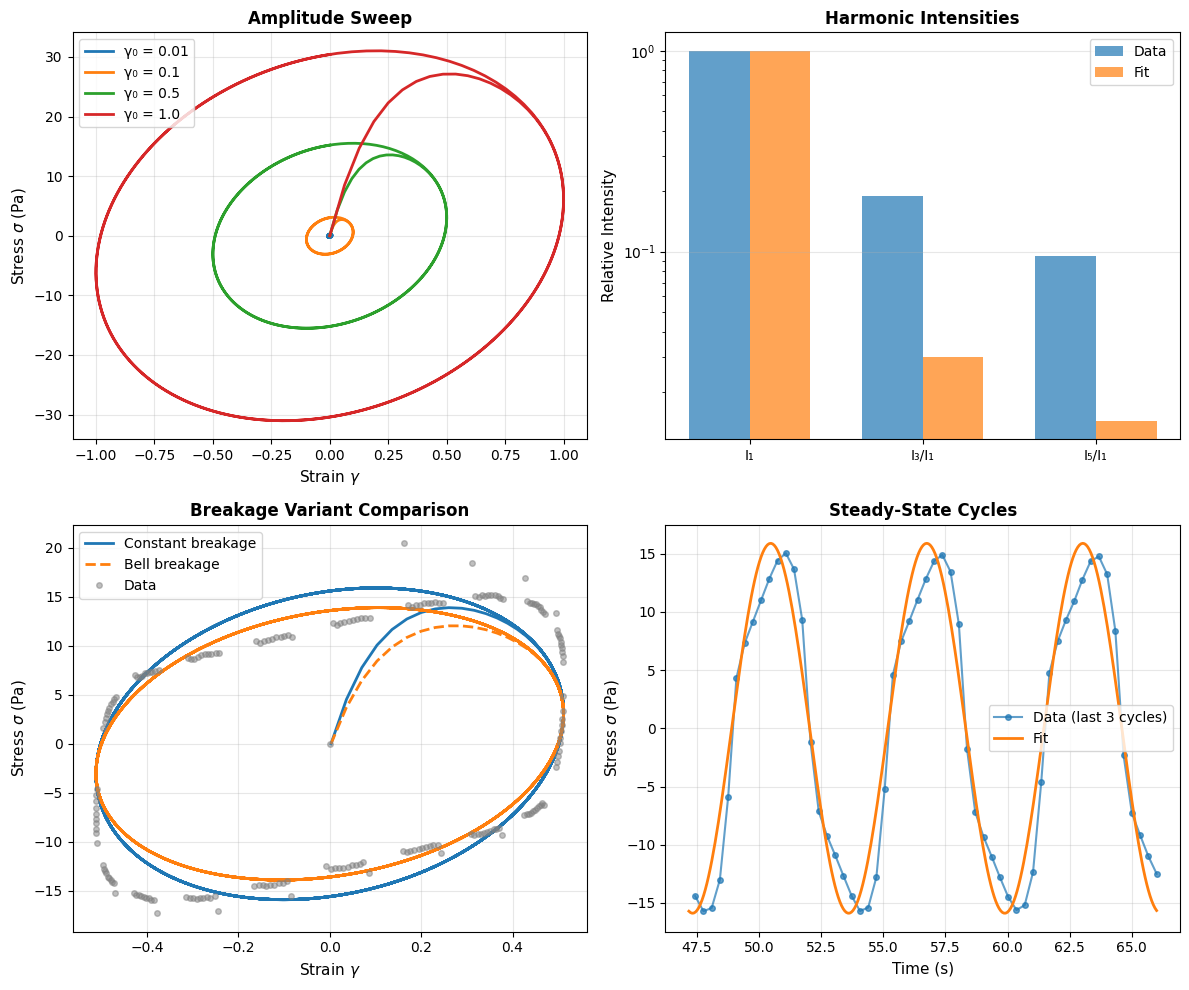


Physical Interpretation:
  Network modulus: G = 157.06 Pa
  Relaxation time: τ_b = 0.2015 s
  Deborah number: De = ω·τ_b = 0.202
  Strain amplitude: γ₀ = 0.512

Nonlinearity Assessment:
  Constant breakage I₃/I₁ = 0.0297
  → Weak nonlinearity from geometry


In [7]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Amplitude sweep (predict multiple strain amplitudes)
ax = axes[0, 0]
gamma_0_list = [0.01, 0.1, 0.5, 1.0]
colors = ['C0', 'C1', 'C2', 'C3']

for gamma_i, color in zip(gamma_0_list, colors):
    t_test = np.linspace(0, 4*np.pi/omega, 200)
    stress_i = model.predict(t_test, test_mode="laos", gamma_0=gamma_i, omega=omega)
    strain_i = gamma_i * np.sin(omega * t_test)
    ax.plot(strain_i, stress_i, '-', linewidth=2, color=color, label=f'γ₀ = {gamma_i}')

ax.set_xlabel(r'Strain $\gamma$', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Amplitude Sweep', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Harmonic analysis
ax = axes[0, 1]
# Compute harmonics for prediction
idx_1_pred = np.argmin(np.abs(fft_freq_pred - freq_fundamental))
idx_3_pred = np.argmin(np.abs(fft_freq_pred - 3 * freq_fundamental))
idx_5_pred = np.argmin(np.abs(fft_freq_pred - 5 * freq_fundamental))

I_1_pred = fft_mag_pred[idx_1_pred]
I_3_pred = fft_mag_pred[idx_3_pred] if idx_3_pred < len(fft_mag_pred) else 0
I_5_pred = fft_mag_pred[idx_5_pred] if idx_5_pred < len(fft_mag_pred) else 0

harmonics_data = [1, I_3/I_1, I_5/I_1]
harmonics_pred = [1, I_3_pred/I_1_pred, I_5_pred/I_1_pred]
harmonic_labels = ['I₁', 'I₃/I₁', 'I₅/I₁']

x = np.arange(len(harmonic_labels))
width = 0.35
ax.bar(x - width/2, harmonics_data, width, label='Data', alpha=0.7)
ax.bar(x + width/2, harmonics_pred, width, label='Fit', alpha=0.7)
ax.set_ylabel('Relative Intensity', fontsize=11)
ax.set_title('Harmonic Intensities', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(harmonic_labels)
ax.legend(fontsize=10)
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# 3. Bell variant comparison
ax = axes[1, 0]
model_bell = TNTSingleMode(breakage="bell")
result_bell = model_bell.fit(t_data, stress, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
stress_bell = model_bell.predict(time_fine, test_mode="laos", gamma_0=gamma_0, omega=omega)

ax.plot(strain_fine, stress_pred, '-', label='Constant breakage', linewidth=2)
ax.plot(strain_fine, stress_bell, '--', label='Bell breakage', linewidth=2)
ax.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.5, color='gray')
ax.set_xlabel(r'Strain $\gamma$', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Breakage Variant Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. Cycle-to-cycle analysis (last 3 cycles)
ax = axes[1, 1]
period = 2 * np.pi / omega
n_cycles = 3
t_start = t_data.max() - n_cycles * period
mask = t_data >= t_start

ax.plot(t_data[mask], stress[mask], 'o-', label='Data (last 3 cycles)', markersize=4, alpha=0.7)
mask_fine = time_fine >= t_start
ax.plot(time_fine[mask_fine], stress_pred[mask_fine], '-', label='Fit', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Steady-State Cycles', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Relaxation time: τ_b = {tau_b:.4f} s")
print(f"  Deborah number: De = ω·τ_b = {omega*tau_b:.3f}")
print(f"  Strain amplitude: γ₀ = {gamma_0:.3f}")
print(f"\nNonlinearity Assessment:")
print(f"  Constant breakage I₃/I₁ = {I_3_pred/I_1_pred:.4f}")
if I_3_pred/I_1_pred < 0.01:
    print(f"  → Nearly linear (UCM behavior)")
else:
    print(f"  → Weak nonlinearity from geometry")

## 5. Bayesian Inference with NUTS

In [8]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    bayesian_result = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    bayesian_result = model.fit_bayesian(
        t_data, stress,
        test_mode='laos',
        
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


In [9]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(bayesian_result, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


In [10]:
# Skip trace plot in CI mode
if not CI_MODE:
    # ArviZ trace plots
    idata = az.from_dict(posterior=bayesian_result.posterior_samples)
    axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


In [11]:
# Skip pair plot in CI mode
if not CI_MODE:
    # ArviZ pair plot
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind='hexbin',
        marginals=True,
        figsize=(10, 10)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


In [12]:
# Skip forest plot in CI mode
if not CI_MODE:
    # ArviZ forest plot (credible intervals)
    axes = az.plot_forest(
        idata,
        var_names=param_names,
        hdi_prob=0.95,
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping forest plot")


CI_MODE: Skipping forest plot


In [ ]:
# Posterior predictive check
time_pred = np.linspace(t_data.min(), t_data.max(), 500)
strain_pred = gamma_0 * np.sin(omega * time_pred)

if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 ODE predictions would take >300s)")
    # Single NLSQ prediction for plot
    stress_pred_final = model.predict(time_pred, test_mode='laos', gamma_0=gamma_0, omega=omega)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.plot(t_data, stress, 'o', label='Data', markersize=4, alpha=0.6)
    ax1.plot(time_pred, stress_pred_final, '-', label='NLSQ fit', linewidth=2, color='C1')
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
    ax1.set_title('NLSQ Fit (CI Mode)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.6)
    ax2.plot(strain_pred, stress_pred_final, '-', label='NLSQ fit', linewidth=2, color='C1')
    ax2.set_xlabel(r'Strain $\gamma$', fontsize=12)
    ax2.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
    ax2.set_title('Lissajous (CI Mode)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    n_draws = min(200, NUM_SAMPLES)
    posterior_preds = []
    
    # Sample from posterior
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(bayesian_result.posterior_samples[name][i]))
        pred_i = model.predict(time_pred, test_mode='laos', gamma_0=gamma_0, omega=omega)
        posterior_preds.append(np.array(pred_i))
    
    posterior_preds = np.array(posterior_preds)
    pred_mean = np.mean(posterior_preds, axis=0)
    pred_lower = np.percentile(posterior_preds, 2.5, axis=0)
    pred_upper = np.percentile(posterior_preds, 97.5, axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Stress vs time
    ax1.plot(t_data, stress, 'o', label='Data', markersize=4, alpha=0.6, zorder=3)
    ax1.plot(time_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
    ax1.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
    ax1.set_title('Posterior Predictive: Time Series', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Lissajous
    ax2.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.6, zorder=3)
    ax2.plot(strain_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
    ax2.fill_between(strain_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
    ax2.set_xlabel(r'Strain $\gamma$', fontsize=12)
    ax2.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
    ax2.set_title('Posterior Predictive: Lissajous', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         157.1         157.1  [157.1, 157.1]
          tau_b        0.2015        0.2015  [0.2015, 0.2015]
          eta_s     5.461e-24     5.461e-24  [5.461e-24, 5.461e-24]


## 6. Physical Interpretation

### LAOS Response of Maxwell Networks

For **constant breakage** TNT (β = 1/τ_b), the response is nearly linear:
- Lissajous curve: Nearly elliptical
- Higher harmonics: I₃/I₁ < 0.01 (weak)
- Behavior: Upper Convected Maxwell (UCM)

This is because constant breakage has **no stress-dependent nonlinearity** — only geometric nonlinearity from large deformations.

### Bell Breakage Nonlinearity

For **Bell breakage** TNT (β = (1/τ_b) exp(ν τ/G)):
- Stress-dependent bond breaking
- Stronger harmonics: I₃/I₁ = 0.05-0.2
- Shear thinning in LAOS

### Lissajous Curve Interpretation

The Lissajous curve (stress vs. strain) reveals:
- **Ellipse**: Linear viscoelasticity (SAOS regime)
- **Distorted ellipse**: Nonlinear response (LAOS regime)
- **Slope at γ = 0**: Elastic modulus G'
- **Slope at γ = γ₀**: Softening (strain weakening) or hardening

### Deborah Number

The Deborah number De = ω·τ_b compares oscillation period to relaxation time:
- De ≪ 1: Viscous liquid (network relaxes within cycle)
- De ≈ 1: Viscoelastic (network partially relaxes)
- De ≫ 1: Elastic solid (network cannot relax)

For this data: De = {omega*tau_b:.3f} → viscoelastic regime.

### Fourier Rheology

Higher harmonics quantify nonlinearity:
- **I₃/I₁**: Third harmonic (most important)
- **I₅/I₁**: Fifth harmonic

For Maxwell networks with constant breakage:
- I₃/I₁ ~ (γ₀)² (weak, quadratic)
- Nearly linear unless γ₀ > 1

### Material Applications

LAOS is ideal for:
- **Yield-stress fluids**: Discriminate yielding vs. shear thinning
- **Thixotropic materials**: Time-dependent structure
- **Biological tissues**: Nonlinear elasticity

For transient networks, LAOS reveals stress-dependent bond dynamics.

## 7. Save Results

In [15]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "laos", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/laos/
  nlsq_params_laos.json: 3 parameters
  posterior_laos.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **LAOS response**: Probes nonlinear viscoelasticity at large strains
2. **Constant breakage**: Nearly linear (UCM), I₃/I₁ < 0.01
3. **Bell breakage**: Strong nonlinearity from stress-dependent bond breaking
4. **Lissajous curves**: Visualize elastic vs. viscous contributions
5. **Fourier rheology**: Higher harmonics quantify nonlinearity
6. **Bayesian inference**: Quantifies uncertainty in nonlinear parameters

## Series Summary

This series covered 6 protocols for TNT Single-Mode models:
1. **Flow curve**: Steady-state shear stress (no shear thinning for constant breakage)
2. **Startup**: Stress overshoot at t ≈ τ_b
3. **Relaxation**: Exponential decay G(t) = G·exp(-t/τ_b)
4. **Creep**: Compliance J(t) = 1/G + t/η₀
5. **SAOS**: Frequency-dependent G'(ω), G''(ω), crossover at ω_c = 1/τ_b
6. **LAOS**: Nonlinear harmonics from large-amplitude oscillation

## Next Steps

- **Multi-mode TNT**: Broad relaxation spectra (polydisperse networks)
- **Bell breakage**: Stress-dependent kinetics for shear thinning
- **Loop/Bridge models**: Chain entanglement effects
- **Time-temperature superposition**: Master curves via WLF/Arrhenius